In [1]:
!pip install emoji

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import numpy as np 
import pandas as pd 
import re
import string
import os
import emoji
import collections
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [3]:
df = pd.read_csv('../dataset/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]

In [4]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['airline_sentiment'] = df.airline_sentiment

In [5]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

3962    hear last call board flight jfk hour ago good ...
3655                        expert seen right rdu airport
1728    pleas dm way get touch someon help platinum aa...
2851                    chanc offer fresh guacamol flight
4410                       ye food add gluten free option
Name: text, dtype: object

In [8]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

15 records have no words left after text cleaning


In [9]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

In [10]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [11]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
,'count_mentions','count_urls','count_words']
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
, ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
, ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
, n_jobs=-1)
pipeline = Pipeline([
('features', features)
, ('clf', LogisticRegression(C=0.8, penalty='l2'))
])
best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

In [22]:
!pip install spacy==3.0
!pip install tweepy
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [12]:
import re

# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('../dataset/3417dataset.csv', quotechar='"', encoding='utf8')


# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text'].map(lambda x: x.lower())

# Clean the url
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', x))

# clean things like "http..."
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('https?', ' ', x))

# clean things like '@xxxxx'
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'(@[A-Za-z]+)"?', '', x))

# clean things like 'rt'
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'(rt)"?', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,\\.!?:]', ' ', x))

# Remove messy code
tweets_df['text_processed'] = tweets_df['text_processed'].apply(lambda x : ''.join(filter(lambda c:ord(c)<256, x)))
# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Think of how else your data can be cleaned

# Print out the first rows 
print(tweets_df['text_processed'].head())

# Removing duplicate tweets?
unique_tweets = list(set(list(tweets_df['text_processed'].values)))
unique_tweets = [t for t in unique_tweets if t]

print(unique_tweets)

0       japan's #olympic building boom is destroyin...
1      keeping canadian horses cool during #olympic...
2       #olympic | a save woh a    _jurado  #fmfpor...
3     _esti  #hagiasophiacathedral   2' 26"at the o...
4       congratulations fencer  for scripting histo...
Name: text_processed, dtype: object
['   #olympic | we are going to tokyo     we are qualified for the upcoming olympics  #fmfpornuestroftbol |#c  0 false2021-03-29 03 00 12 blessedwsophia mentally at a tv show con     #olympic | we are going to tokyo     ', ' _spos_en  breaking  tokyo #olympic ceremonies chief officially resigns over comedian insult 2021-03-18 03 24 01 haroldsinnott miami', '_taipei   unlike japan and its 2021 #olympic  international activities are still happen ', 'soccer  us look to take major step forward in olympic qualifying bid #olympic #soccer ', '   the international #olympic committee and china have teamed up to offer vaccines to athletes and teams preparing for the 0', '  filed a complaint

In [13]:
new_tweets = pd.Series(unique_tweets)
df_counts_neg = tc.transform(new_tweets)
df_clean_neg = ct.transform(new_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg
output = best_model.predict(df_model_neg).tolist()
#print(output)

In [14]:
sentiment_list = list(0 for x in range (3))
#print(sentiment_list)
for i in range (len(output)):
    if output[i] == 'negative':
        sentiment_list[0] += 1
    if output[i] == 'positive':
        sentiment_list[2] += 1
    if output[i] == 'neutral':
        sentiment_list[1] += 1

#print(sentiment_list)

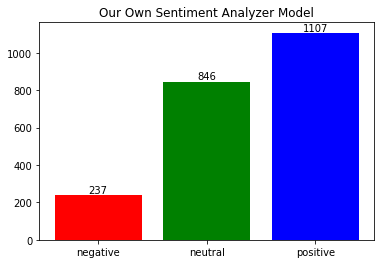

In [15]:
name_list = ['negative','neutral','positive']   
plt.bar(range(len(sentiment_list)), sentiment_list,color='rgb',tick_label=name_list) 
for x,y in zip(range(len(name_list)),sentiment_list):
    plt.text(x, y, y, ha='center', va= 'bottom')
plt.title('Our Own Sentiment Analyzer Model')
plt.show() 
plt.show()  